In [ ]:
!pip install captum torch torchvision pandas pillow matplotlib scikit-learn

Starting training...
Epoch 1/1
Batch [0/2501] Loss: 1.9035 D_Loss: 0.7707
Batch [100/2501] Loss: 0.8330 D_Loss: 0.0163
Batch [200/2501] Loss: 1.7585 D_Loss: 0.0060
Batch [300/2501] Loss: 1.7180 D_Loss: 0.0031
Batch [400/2501] Loss: 0.5970 D_Loss: 0.0019
Batch [500/2501] Loss: 1.4704 D_Loss: 0.0010
Batch [600/2501] Loss: 1.6486 D_Loss: 0.0007
Batch [700/2501] Loss: 1.5727 D_Loss: 0.0007
Batch [800/2501] Loss: 0.7625 D_Loss: 0.0004
Batch [900/2501] Loss: 0.9863 D_Loss: 0.0003
Batch [1000/2501] Loss: 3.6862 D_Loss: 0.0004
Batch [1100/2501] Loss: 3.0700 D_Loss: 0.0003
Batch [1200/2501] Loss: 0.9117 D_Loss: 0.0002
Batch [1300/2501] Loss: 1.9533 D_Loss: 0.0003
Batch [1400/2501] Loss: 0.6920 D_Loss: 0.0001
Batch [1500/2501] Loss: 2.1397 D_Loss: 0.0001
Batch [1600/2501] Loss: 0.7622 D_Loss: 0.0001
Batch [1700/2501] Loss: 0.9554 D_Loss: 0.0001
Batch [1800/2501] Loss: 1.4697 D_Loss: 0.0001
Batch [1900/2501] Loss: 0.7765 D_Loss: 0.0001
Batch [2000/2501] Loss: 0.9547 D_Loss: 0.0001
Batch [2100/250

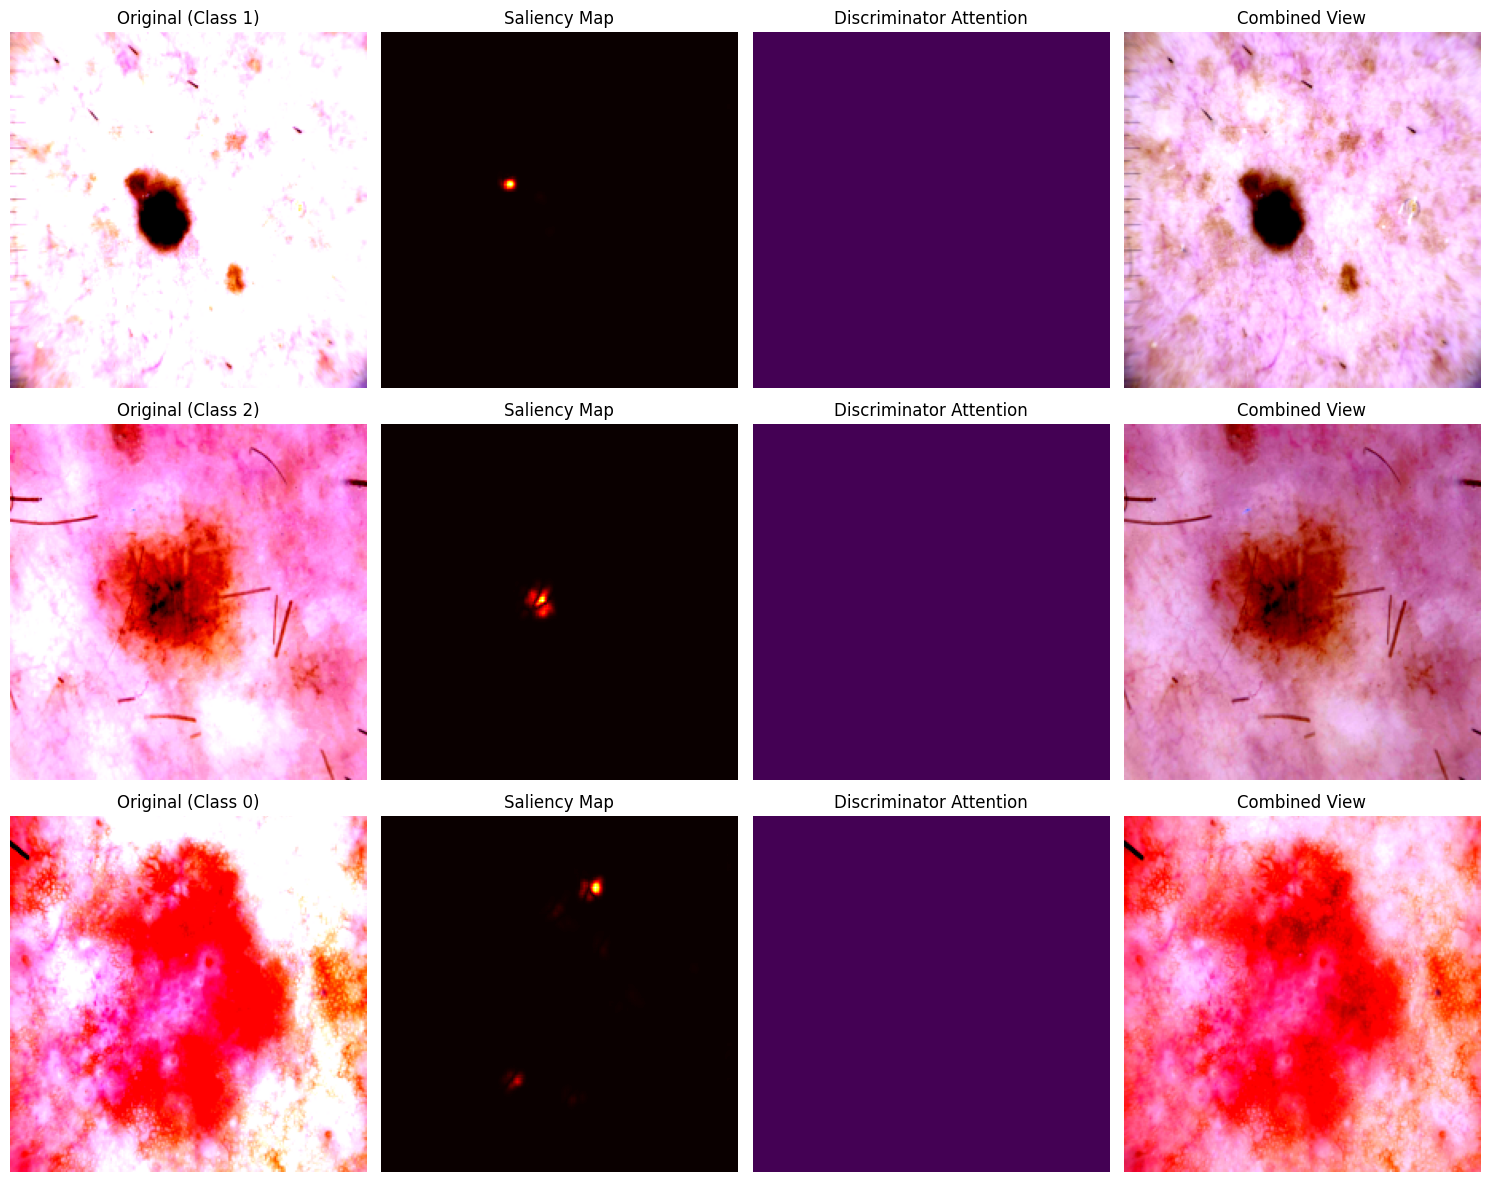

Few-shot learning visualization:


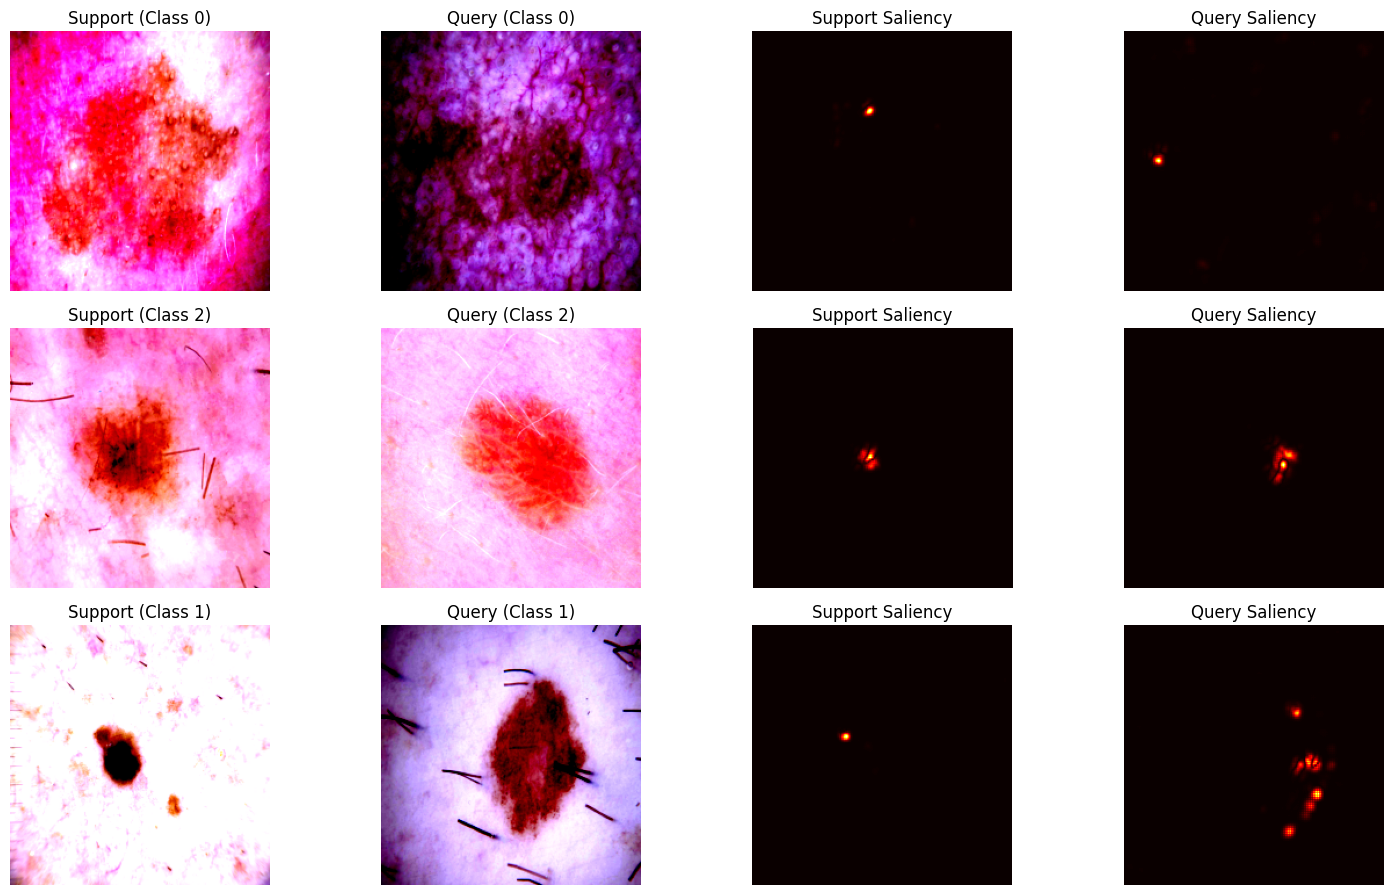

In [ ]:
# Imports
import os

import pandas as pd

from PIL import Image

import torch

import torch.nn as nn

import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt

from captum.attr import Saliency

import time

from sklearn.metrics import accuracy_score



# Dataset Class

class HAM10000Dataset(Dataset):

    def __init__(self, csv_file, img_dirs, transform=None):

        self.data = pd.read_csv(csv_file)

        self.img_dirs = img_dirs

        self.transform = transform



    def __len__(self):

        return len(self.data)



    def __getitem__(self, idx):

        img_name = self.data.iloc[idx]['image_id'] + '.jpg'

        

        for img_dir in self.img_dirs:

            img_path = os.path.join(img_dir, img_name)

            if os.path.exists(img_path):

                image = Image.open(img_path).convert('RGB')

                break

        

        label = self.data.iloc[idx]['dx']

        label_map = {label: idx for idx, label in enumerate(self.data['dx'].unique())}

        label = label_map[label]



        if self.transform:

            image = self.transform(image)



        return image, label



# Attention Module

class AttentionBlock(nn.Module):

    def __init__(self, in_channels):

        super().__init__()

        self.query = nn.Conv2d(in_channels, in_channels//8, 1)

        self.key = nn.Conv2d(in_channels, in_channels//8, 1)

        self.value = nn.Conv2d(in_channels, in_channels, 1)

        

    def forward(self, x):

        batch, channels, height, width = x.size()

        q = self.query(x).view(batch, -1, height*width).permute(0,2,1)

        k = self.key(x).view(batch, -1, height*width)

        v = self.value(x).view(batch, -1, height*width)

        

        attn = torch.bmm(q, k)

        attn = F.softmax(attn, dim=2)

        out = torch.bmm(v, attn.permute(0,2,1))

        return out.view(batch, channels, height, width)



# UNet blocks

class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, 3, padding=1),

            nn.BatchNorm2d(out_channels),

            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),

            nn.BatchNorm2d(out_channels),

            nn.ReLU(inplace=True)

        )

        

    def forward(self, x):

        return self.conv(x)



# UNet with Attention

class UNetWithAttention(nn.Module):

    def __init__(self, n_channels, n_classes):

        super().__init__()

        self.inc = DoubleConv(n_channels, 64)

        self.down1 = nn.Sequential(

            nn.MaxPool2d(2),

            DoubleConv(64, 128)

        )

        self.attention1 = AttentionBlock(128)

        self.down2 = nn.Sequential(

            nn.MaxPool2d(2),

            DoubleConv(128, 256)

        )

        self.attention2 = AttentionBlock(256)

        

        self.classifier = nn.Sequential(

            nn.AdaptiveAvgPool2d((1,1)),

            nn.Flatten(),

            nn.Linear(256, n_classes)

        )

        

    def forward(self, x):

        x1 = self.inc(x)

        x2 = self.down1(x1)

        x2 = self.attention1(x2)

        x3 = self.down2(x2)

        x3 = self.attention2(x3)

        return self.classifier(x3)



# Discriminator

class Discriminator(nn.Module):

    def __init__(self):

        super().__init__()

        self.main = nn.Sequential(

            nn.Conv2d(3, 64, 4, 2, 1),

            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),

            nn.BatchNorm2d(128),

            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),

            nn.BatchNorm2d(256),

            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(),

            nn.Linear(256, 1),

            nn.Sigmoid()

        )

    

    def forward(self, x):

        return self.main(x)



class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_dim=64):
        super().__init__()
        self.main = nn.Sequential(
            # Initial projection and reshape
            nn.Linear(latent_dim, 4*4*feature_dim*8),
            nn.BatchNorm1d(4*4*feature_dim*8),
            nn.ReLU(True),
            
            # Reshape to start convolutions
            nn.Unflatten(1, (feature_dim*8, 4, 4)),
            
            # Transposed convolutions
            nn.ConvTranspose2d(feature_dim*8, feature_dim*4, 4, 2, 1),
            nn.BatchNorm2d(feature_dim*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_dim*4, feature_dim*2, 4, 2, 1),
            nn.BatchNorm2d(feature_dim*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_dim*2, feature_dim, 4, 2, 1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_dim, 3, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.main(z)

# Visualization function

def visualize_comparison(model, dataset, n_samples=3):

    plt.figure(figsize=(15, 4*n_samples))

    

    indices = np.random.choice(len(dataset), n_samples, replace=False)

    

    for idx, sample_idx in enumerate(indices):

        image, label = dataset[sample_idx]

        image = image.to(device)

        

        saliency_map = generate_saliency_map(model, image, label)

        

        with torch.no_grad():

            d_output = discriminator(image.unsqueeze(0))

        

        plt.subplot(n_samples, 4, idx*4 + 1)

        plt.imshow(image.cpu().permute(1,2,0))

        plt.title(f'Original (Class {label})')

        plt.axis('off')

        

        plt.subplot(n_samples, 4, idx*4 + 2)

        plt.imshow(saliency_map.mean(axis=0), cmap='hot')

        plt.title('Saliency Map')

        plt.axis('off')

        

        plt.subplot(n_samples, 4, idx*4 + 3)

        attention = d_output.cpu().numpy().reshape(1, -1)

        plt.imshow(attention, cmap='viridis')

        plt.title('Discriminator Attention')

        plt.axis('off')

        

        plt.subplot(n_samples, 4, idx*4 + 4)

        overlay = image.cpu().permute(1,2,0).numpy()

        overlay = overlay * 0.7 + np.expand_dims(saliency_map.mean(axis=0), -1) * 0.3

        plt.imshow(overlay)

        plt.title('Combined View')

        plt.axis('off')

    

    plt.tight_layout()

    plt.show()

# Saliency map visualization

def generate_saliency_map(model, input_image, target_class=0):

    """

    Generate saliency map for a given input image and target class

    Args:

        model: trained model

        input_image: input tensor

        target_class: target class index

    """
    model.eval()
    saliency = Saliency(model)
    input_image = input_image.unsqueeze(0).requires_grad_()   
    # Create target for specific class
    target = torch.tensor([target_class]).to(device)
    # Calculate attribution
    attribution = saliency.attribute(input_image, target=target)
    return attribution.squeeze().cpu().detach().numpy() 
    
def calculate_accuracy(model, data_loader, device):
    model.eval()
    predictions = []
    actual = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            actual.extend(target.cpu().numpy())
    
    return accuracy_score(actual, predictions)
    
# Training function

def train_epoch(model, discriminator, train_loader, criterion, optimizer, d_optimizer):
    model.train()
    discriminator.train()
    epoch_loss = 0
    epoch_d_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        batch_size = data.size(0)
        
        # Train discriminator
        d_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        
        d_real = discriminator(data)
        d_real_loss = F.binary_cross_entropy(d_real, real_labels)
        d_real_loss.backward()
        d_optimizer.step()
        
        # Train classifier
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_d_loss += d_real_loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f} D_Loss: {d_real_loss.item():.4f}')
    
    # Fixed return statement
    return (epoch_loss / len(train_loader)), (epoch_d_loss / len(train_loader))

def train_gan(generator, discriminator, train_loader, g_optimizer, d_optimizer):
    real_label = 1
    fake_label = 0
    
    for batch_idx, (real_data, _) in enumerate(train_loader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)
        
        # Train Discriminator
        d_optimizer.zero_grad()
        label_real = torch.full((batch_size,), real_label, device=device)
        output_real = discriminator(real_data)
        d_loss_real = F.binary_cross_entropy(output_real, label_real)
        
        noise = torch.randn(batch_size, 100, device=device)
        fake_data = generator(noise)
        label_fake = torch.full((batch_size,), fake_label, device=device)
        output_fake = discriminator(fake_data.detach())
        d_loss_fake = F.binary_cross_entropy(output_fake, label_fake)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        output_fake = discriminator(fake_data)
        g_loss = F.binary_cross_entropy(output_fake, label_real)
        g_loss.backward()
        g_optimizer.step()
        
        return d_loss.item(), g_loss.item()

# Setup and training

if __name__ == "__main__":

    # Data paths

    metadata_path = "../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

    image_dirs = [

        "../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",

        "../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

    ]

    

    # Load metadata

    metadata = pd.read_csv(metadata_path)

    train_metadata, test_metadata = train_test_split(metadata, test_size=0.001, random_state=42)

    

    # Save splits

    train_metadata.to_csv("train_metadata.csv", index=False)

    test_metadata.to_csv("test_metadata.csv", index=False)

    

    # Setup transforms

    transform = transforms.Compose([

        transforms.Resize((224, 224)),

        transforms.ToTensor(),

        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])

    

    # Create datasets

    train_dataset = HAM10000Dataset("train_metadata.csv", image_dirs, transform=transform)

    test_dataset = HAM10000Dataset("test_metadata.csv", image_dirs, transform=transform)

    

    # Create dataloaders

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

    test_loader = DataLoader(test_dataset, batch_size=4)

    

    # Setup device

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    

    # Initialize models

    model = UNetWithAttention(3, 7).to(device)

    discriminator = Discriminator().to(device)

    latent_dim = 100
    generator = Generator(latent_dim).to(device)
    

    # Setup optimizers

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters())

    d_optimizer = torch.optim.Adam(discriminator.parameters())
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
   

    # Training

    n_epochs = 1

    train_losses = []

    train_accuracies = []

    training_time = []

    

    print("Starting training...")

    total_start_time = time.time()

    

    for epoch in range(n_epochs):

        epoch_start_time = time.time()

        print(f'Epoch {epoch+1}/{n_epochs}')

        

        train_loss, d_loss = train_epoch(model, discriminator, train_loader, criterion, optimizer, d_optimizer)

        train_acc = calculate_accuracy(model, train_loader, device)

        

        epoch_time = time.time() - epoch_start_time

        training_time.append(epoch_time)

        train_losses.append(train_loss)

        train_accuracies.append(train_acc)

        

        print(f'Epoch {epoch+1}: Loss={train_loss:.4f}, Accuracy={train_acc:.4f}, Time={epoch_time:.2f}s')

    

    total_time = time.time() - total_start_time

    print(f"\nTraining completed in {total_time/60:.2f} minutes")

    

    # Visualize results

    visualize_comparison(model, test_dataset)



# Helper functions for few-shot learning visualization

def get_support_query_pairs(dataset, n_way=5, k_shot=1):

    """Get support and query image pairs for few-shot learning"""

    classes = list(set([label for _, label in dataset]))

    n_way = min(n_way, len(classes))  # Ensure n_way does not exceed number of classes

    

    selected_classes = np.random.choice(classes, n_way, replace=False)

    

    support_images = []

    query_images = []

    

    for cls in selected_classes:

        class_indices = [i for i, (_, label) in enumerate(dataset) if label == cls]

        selected_indices = np.random.choice(class_indices, k_shot + 1, replace=False)

        

        support_images.extend([(dataset[i][0], cls) for i in selected_indices[:k_shot]])

        query_images.extend([(dataset[i][0], cls) for i in selected_indices[k_shot:]])

    

    return support_images, query_images



def visualize_few_shot_comparison(model, dataset, n_way=5, k_shot=1):

    """Visualize few-shot learning comparison"""

    support_images, query_images = get_support_query_pairs(dataset, n_way, k_shot)

    

    fig = plt.figure(figsize=(15, 3*n_way))

    

    for idx, ((support_img, support_label), (query_img, query_label)) in enumerate(zip(support_images, query_images)):

        support_img = support_img.to(device)

        query_img = query_img.to(device)

        

        with torch.no_grad():

            support_pred = model(support_img.unsqueeze(0))

            query_pred = model(query_img.unsqueeze(0))

        

        support_saliency = generate_saliency_map(model, support_img, support_label)

        query_saliency = generate_saliency_map(model, query_img, query_label)

        

        plt.subplot(n_way, 4, idx*4 + 1)

        plt.imshow(support_img.cpu().permute(1,2,0))

        plt.title(f'Support (Class {support_label})')

        plt.axis('off')

        

        plt.subplot(n_way, 4, idx*4 + 2)

        plt.imshow(query_img.cpu().permute(1,2,0))

        plt.title(f'Query (Class {query_label})')

        plt.axis('off')

        

        plt.subplot(n_way, 4, idx*4 + 3)

        plt.imshow(support_saliency.mean(axis=0), cmap='hot')

        plt.title('Support Saliency')

        plt.axis('off')

        

        plt.subplot(n_way, 4, idx*4 + 4)

        plt.imshow(query_saliency.mean(axis=0), cmap='hot')

        plt.title('Query Saliency')

        plt.axis('off')

    

    plt.tight_layout()

    plt.show()



# Add to training loop

def evaluate_few_shot(model, test_dataset):

    model.eval()

    visualize_few_shot_comparison(model, test_dataset)

    

# Call after training

print("Few-shot learning visualization:")

evaluate_few_shot(model, test_dataset)